<a href="https://colab.research.google.com/github/melvin018/Computer-Vision--Group-B/blob/main/dl_face_expression1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#importing necessary libraries
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from scipy.linalg import sqrtm
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, array_to_img

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# loading  data.csv file
file_path = '/content/drive/MyDrive/FaceExpressions (2)/data.csv'
data = pd.read_csv(file_path)

In [ ]:
print(data.head())


   Unnamed: 0                                               path     label
0           0  Surprise/1bd930d6a1c717c11be33db74823f661cb53f...  Surprise
1           1       Surprise/cropped_emotions.100096~12fffff.png  Surprise
2           2  Surprise/0df0e470e33093f5b72a8197fa209d684032c...  Surprise
3           3       Surprise/cropped_emotions.260779~12fffff.png  Surprise
4           4       Surprise/cropped_emotions.263616~12fffff.png  Surprise


In [4]:
# loading dataset file
base_path = '/content/drive/MyDrive/FaceExpressions (2)/dataset'


In [7]:
# #updating the paths to include the base_path
data['path'] = data['path'].apply(lambda x: os.path.join(base_path, x))


In [ ]:
print(data.head())

   Unnamed: 0                                               path     label
0           0  /Users/anjalibhardwaj/Desktop/College/Deep Lea...  Surprise
1           1  /Users/anjalibhardwaj/Desktop/College/Deep Lea...  Surprise
2           2  /Users/anjalibhardwaj/Desktop/College/Deep Lea...  Surprise
3           3  /Users/anjalibhardwaj/Desktop/College/Deep Lea...  Surprise
4           4  /Users/anjalibhardwaj/Desktop/College/Deep Lea...  Surprise


In [ ]:
# Example: Select 100 random rows
df = data.sample(n=50)


In [ ]:
images = [50]
labels = [50]


In [21]:
#preprocessing images
def load_and_preprocess_images(data, image_size=(64, 64)):
    images = [50]
    labels = [50]
    for index, row in data.iterrows():
        label = row['label']
        image_path = row['path']
        image = tf.io.read_file(image_path)
        image = tf.image.decode_image(image, channels=3)
        image = tf.image.resize(image, image_size)
        image = (image - 127.5) / 127.5  # normalize to [-1, 1]
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


In [ ]:
#apply fxn to data
images, labels = load_and_preprocess_images(data)

In [ ]:
#print the shapes of the images and labels
print(images.shape, labels.shape)


(15453, 64, 64, 3) (15453,)


In [ ]:
#encodes the labels
label_to_index = {label: index for index, label in enumerate(np.unique(labels))}
index_to_label = {index: label for label, index in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])


In [ ]:
#split the data set itno training and validation sets
train_img, val_img, train_lbl, val_lbl = train_test_split(images, labels, test_size=0.2, random_state=42)

In [ ]:
#create tensorflow datasets for training and validation
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_img, train_lbl)).shuffle(buffer_size=1024).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_img, val_lbl)).batch(batch_size)



In [ ]:
#printing checking if images are loaded correctly
print(f"Number of train images: {len(train_img)}")
print(f"Number of testing images: {len(val_img)}")

Number of train images: 12362
Number of testing images: 3091


In [ ]:
print(f"train_images shape: {train_img.shape}")

train_images shape: (12362, 64, 64, 3)


Training images:


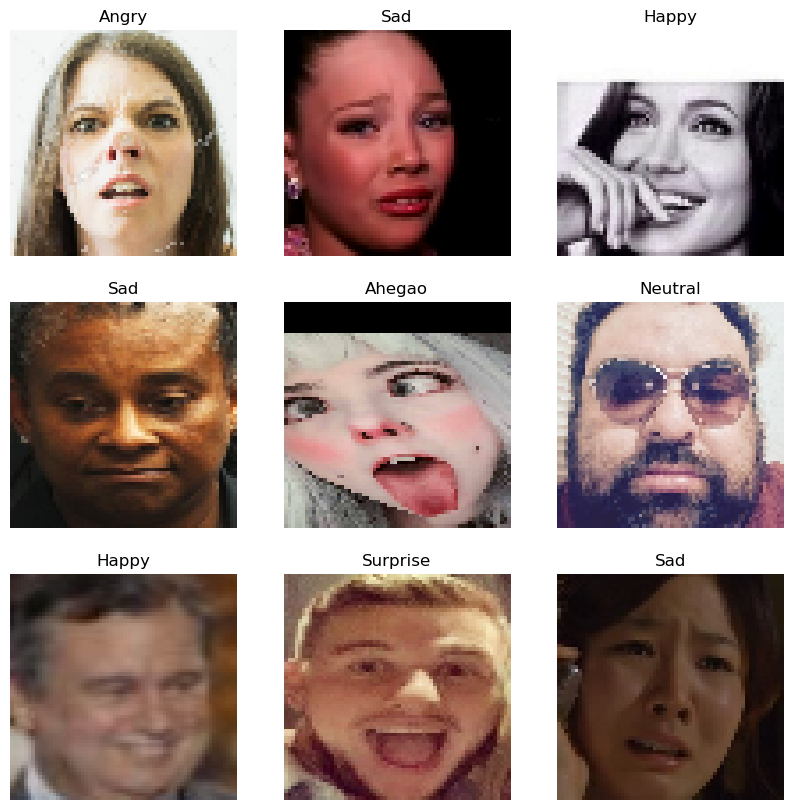

In [ ]:
import matplotlib.pyplot as plt
# Display sample  images from the training dataset
print("Training images:")
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((train_img[i] + 1) / 2)
    plt.title(index_to_label[train_lbl[i]])
    plt.axis('off')
plt.show()

Validation images:


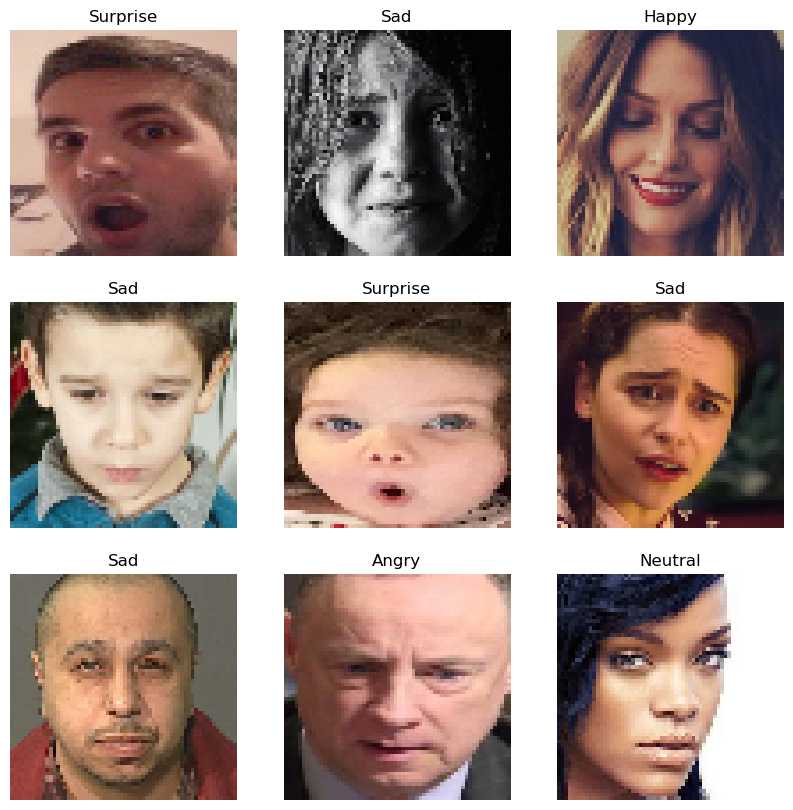

In [ ]:
# Display sample images from the validation dataset
print("Validation images:")
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((val_img[i] + 1) / 2)
    plt.title(index_to_label[val_lbl[i]])
    plt.axis('off')
plt.show()

In [ ]:
#image data generator for  augmnetation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
#  applying augmentation to a batch of training images
if train_img.shape[0] > 0:
    augmented_images = next(datagen.flow(train_img, batch_size=32))
    print(f"Augmented images shape: {augmented_images.shape}")
else:
    print("No training images available for augmentation.")

Augmented images shape: (32, 64, 64, 3)


In [ ]:
# define and apply gaussian blur
import cv2
def apply_gaussian_blur(images, kernel_size=(5, 5), sigma=0):
    blurred_images = [cv2.GaussianBlur(image, kernel_size, sigma) for image in images]
    return np.array(blurred_images)

blurred_train_images = apply_gaussian_blur(train_img)
blurred_test_images = apply_gaussian_blur(val_img)

In [ ]:
# apply histogram equalization
def apply_histogram_equalization(images):
    equalized_images = []
    for img in images:
        img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2YCrCb)
        channels = cv2.split(img)
        cv2.equalizeHist(channels[0], channels[0])
        img = cv2.merge(channels)
        img = cv2.cvtColor(img, cv2.COLOR_YCrCb2RGB)
        equalized_images.append(img / 255.0)
    return np.array(equalized_images)

equalized_train_images = apply_histogram_equalization(train_img)
equalized_test_images = apply_histogram_equalization(val_img)

/var/folders/k9/kk8b8sgd09d16tn1cy7l_shr0000gn/T/ipykernel_10115/464278611.py:5: RuntimeWarning: invalid value encountered in cast
  img = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2YCrCb)


In [ ]:
# apply intensity thresholds
def apply_intensity_threshold(images, threshold_value=127):
    threshold_images = []
    for img in images:
        gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)
        _, binary = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)
        binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2RGB)
        threshold_images.append(binary / 255.0)
    return np.array(threshold_images)

threshold_train_images = apply_intensity_threshold(train_img)
threshold_test_images = apply_intensity_threshold(val_img)

/var/folders/k9/kk8b8sgd09d16tn1cy7l_shr0000gn/T/ipykernel_10115/2802697279.py:5: RuntimeWarning: invalid value encountered in cast
  gray = cv2.cvtColor((img * 255).astype('uint8'), cv2.COLOR_RGB2GRAY)


In [ ]:
# define the generator model for the GAN

import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_14             │ (None, 8, 8, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 16, 16, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_26 (LeakyReLU)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 32, 32, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_27 (LeakyReLU)      │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 64, 64, 3)      │         2,400 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,432 (10.61 MB)

 Trainable params: 2,749,216 (10.49 MB)

 Non-trainable params: 33,216 (129.75 KB)

In [ ]:
#define the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()


/Users/anjalibhardwaj/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_28 (LeakyReLU)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_29 (LeakyReLU)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │        16,385 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,045,633 (3.99 MB)

 Trainable params: 1,045,633 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# define loss and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [ ]:
#training WGAN
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [ ]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

In [ ]:
#TRAINING PARAMETERES
noise_dim = 100
num_examples_to_generate = 16
EPOCHS = 10

In [ ]:
#random noise seed used for generating images during training.
seed = tf.random.normal([num_examples_to_generate, noise_dim])



In [ ]:
# train the model
train(train_dataset, EPOCHS)

2024-07-15 16:00:05.018821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 1 is 247.44712090492249 sec


2024-07-15 16:04:07.545880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 2 is 242.5221881866455 sec


2024-07-15 16:07:53.307748: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 3 is 225.76141119003296 sec


2024-07-15 16:11:41.222165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 4 is 227.91431999206543 sec


2024-07-15 16:15:32.718713: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 5 is 231.49647998809814 sec


2024-07-15 16:19:26.474943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 6 is 233.7562220096588 sec


2024-07-15 16:23:31.047676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 7 is 244.57277083396912 sec


2024-07-15 16:27:27.350635: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 8 is 236.30282378196716 sec


2024-07-15 16:31:31.216642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Time for epoch 9 is 243.86612200737 sec
Time for epoch 10 is 261.32203793525696 sec


2024-07-15 16:35:52.538665: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
#calculating inception score
import tensorflow_hub as hub

def calculate_inception_score(images):
    # Use a pre-trained InceptionV3 model from TensorFlow Hub
    inception_model = hub.load('https://tfhub.dev/google/tf2-preview/inception_v3/classification/4')

    processed_images = tf.image.resize(images, (299, 299))  # InceptionV3 requires 299x299 input size
    processed_images = tf.image.convert_image_dtype(processed_images, tf.float32)

    predictions = inception_model(processed_images)
    predictions = tf.nn.softmax(predictions)

    scores = []
    for i in range(len(predictions)):
        score = tf.reduce_sum(predictions[i] * tf.math.log(predictions[i] + 1e-6))
        scores.append(score)

    inception_score = tf.exp(tf.reduce_mean(scores))
    return inception_score.numpy()
# calculateing FID
def calculate_fid(real_images, generated_images):
    real_images = tf.image.resize(real_images, (299, 299))
    generated_images = tf.image.resize(generated_images, (299, 299))

    inception_model = tf.keras.applications.InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    real_features = inception_model.predict(real_images)
    generated_features = inception_model.predict(generated_images)

    mu_real = np.mean(real_features, axis=0)
    sigma_real = np.cov(real_features, rowvar=False)

    mu_gen = np.mean(generated_features, axis=0)
    sigma_gen = np.cov(generated_features, rowvar=False)

    ssdiff = np.sum((mu_real - mu_gen)**2.0)
    covmean = sqrtm(sigma_real.dot(sigma_gen))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma_real + sigma_gen - 2.0 * covmean)
    return fid

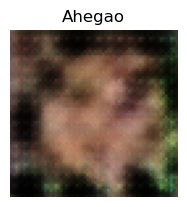

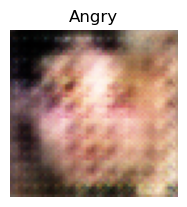

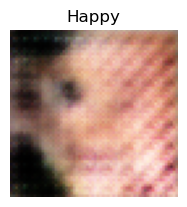

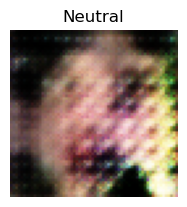

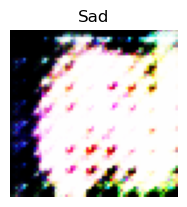

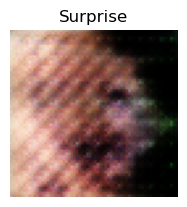

In [ ]:
def generate_and_save_images(model, epoch, test_input, label):
    predictions = model(test_input, training=False)

    plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i] + 1) / 2)
        plt.title(label)
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

for label, index in label_to_index.items():
    seed = tf.random.normal([1, noise_dim])
    generate_and_save_images(generator, EPOCHS, seed, label)

In [5]:

# Calculate Inception Score
mean, std = calculate_inception_score(inception_model, dataloader, batch_size, splits=10)
print(f"Inception Score: Mean = {mean}, Std = {std}")

NameError: name 'calculate_inception_score' is not defined